In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [2]:
# Load the data
df = pd.read_pickle("../data/df.pickle")

In [3]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] < "2021-01-01")].dropna()

In [4]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp

In [5]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [6]:
node_2020, edge_2020, timestamp_2020 = getNetworkAnalysis(df_2020)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)

In [7]:
alpha_lockdown, beta_lockdown = 0.086, 1.257
alpha_after_lockdown, beta_after_lockdown = 0.085, 5.735
alpha_stayhome, beta_stayhome = 0.085, 1.626
alpha_after_stayhome, beta_after_stayhome = 0.094, 3.621
alpha_2020, beta_2020 = 0.075, 0.795 
alpha_2021, beta_2021 = 0.087, 2.238
alpha_2022, beta_2022 = 0.118, 8.603
alpha_2023, beta_2023 = 0.119, 7.9

Np = 1652

In [8]:
node_lockdown, edge_lockdown, timestamp_lockdown = getNetworkAnalysis(df_lockdown)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown = getNetworkAnalysis(df_20200601_20201116)
node_stayhome, edge_stayhome, timestamp_stayhome = getNetworkAnalysis(df_20201117_20201216)
node_after_stayhome, edge_after_stayhome, timestamp_after_stayhome = getNetworkAnalysis(df_20201217_20201231)

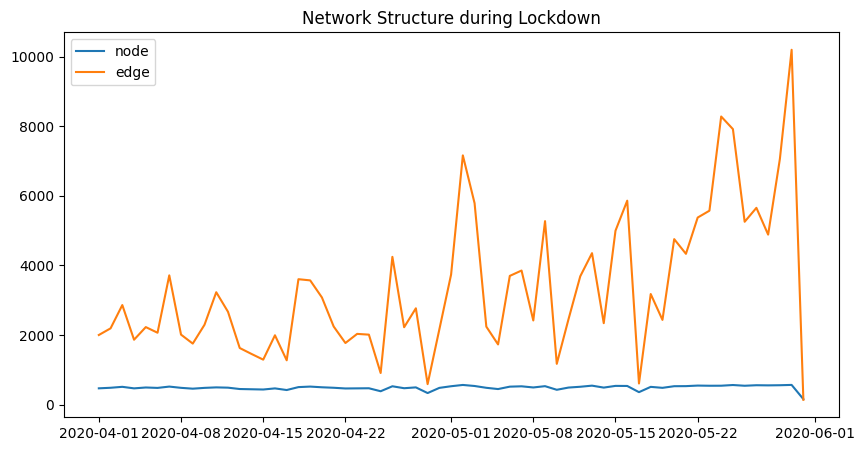

In [9]:
# ネットワークの構造がどのようであるのかを可視化
plt.figure(figsize=(10, 5))
plt.plot(timestamp_lockdown, node_lockdown, label='node')
plt.plot(timestamp_lockdown, edge_lockdown, label='edge')
plt.title('Network Structure during Lockdown')
plt.legend()
plt.show()

In [9]:
kappa_lockdown = []
for i in range(len(edge_lockdown)):
    alpha, beta = alpha_lockdown, beta_lockdown
    kappa_lockdown.append(kappa(edge_lockdown[i], Np))

In [10]:
kappa_after_lockdown = []
for i in range(len(edge_after_lockdown)):
    alpha, beta = alpha_after_lockdown, beta_after_lockdown
    kappa_after_lockdown.append(kappa(edge_after_lockdown[i], Np))

In [11]:
kappa_stayhome = []
for i in range(len(edge_stayhome)):
    alpha, beta = alpha_stayhome, beta_stayhome
    kappa_stayhome.append(kappa(edge_stayhome[i], Np))

In [12]:
kappa_after_stayhome = []
for i in range(len(edge_after_stayhome)):
    alpha, beta = alpha_after_stayhome, beta_after_stayhome
    kappa_after_stayhome.append(kappa(edge_after_stayhome[i], Np))

In [13]:
kappa_2020 = []
for i in range(len(edge_2020)):
    alpha, beta = alpha_2020, beta_2020
    kappa_2020.append(kappa(edge_2020[i], Np=Np))

In [14]:
kappa_2021 = []
for i in range(len(edge_2021)):
    alpha, beta = alpha_2021, beta_2021
    kappa_2021.append(kappa(edge_2021[i],Np=Np))

In [15]:
kappa_2022 = []
for i in range(len(edge_2022)):
    alpha, beta = alpha_2022, beta_2022
    kappa_2022.append(kappa(edge_2022[i],Np=Np))

In [16]:
kappa_2023 = []
for i in range(len(edge_2023)):
    alpha, beta = alpha_2023, beta_2023
    kappa_2023.append(kappa(edge_2023[i],Np=Np))

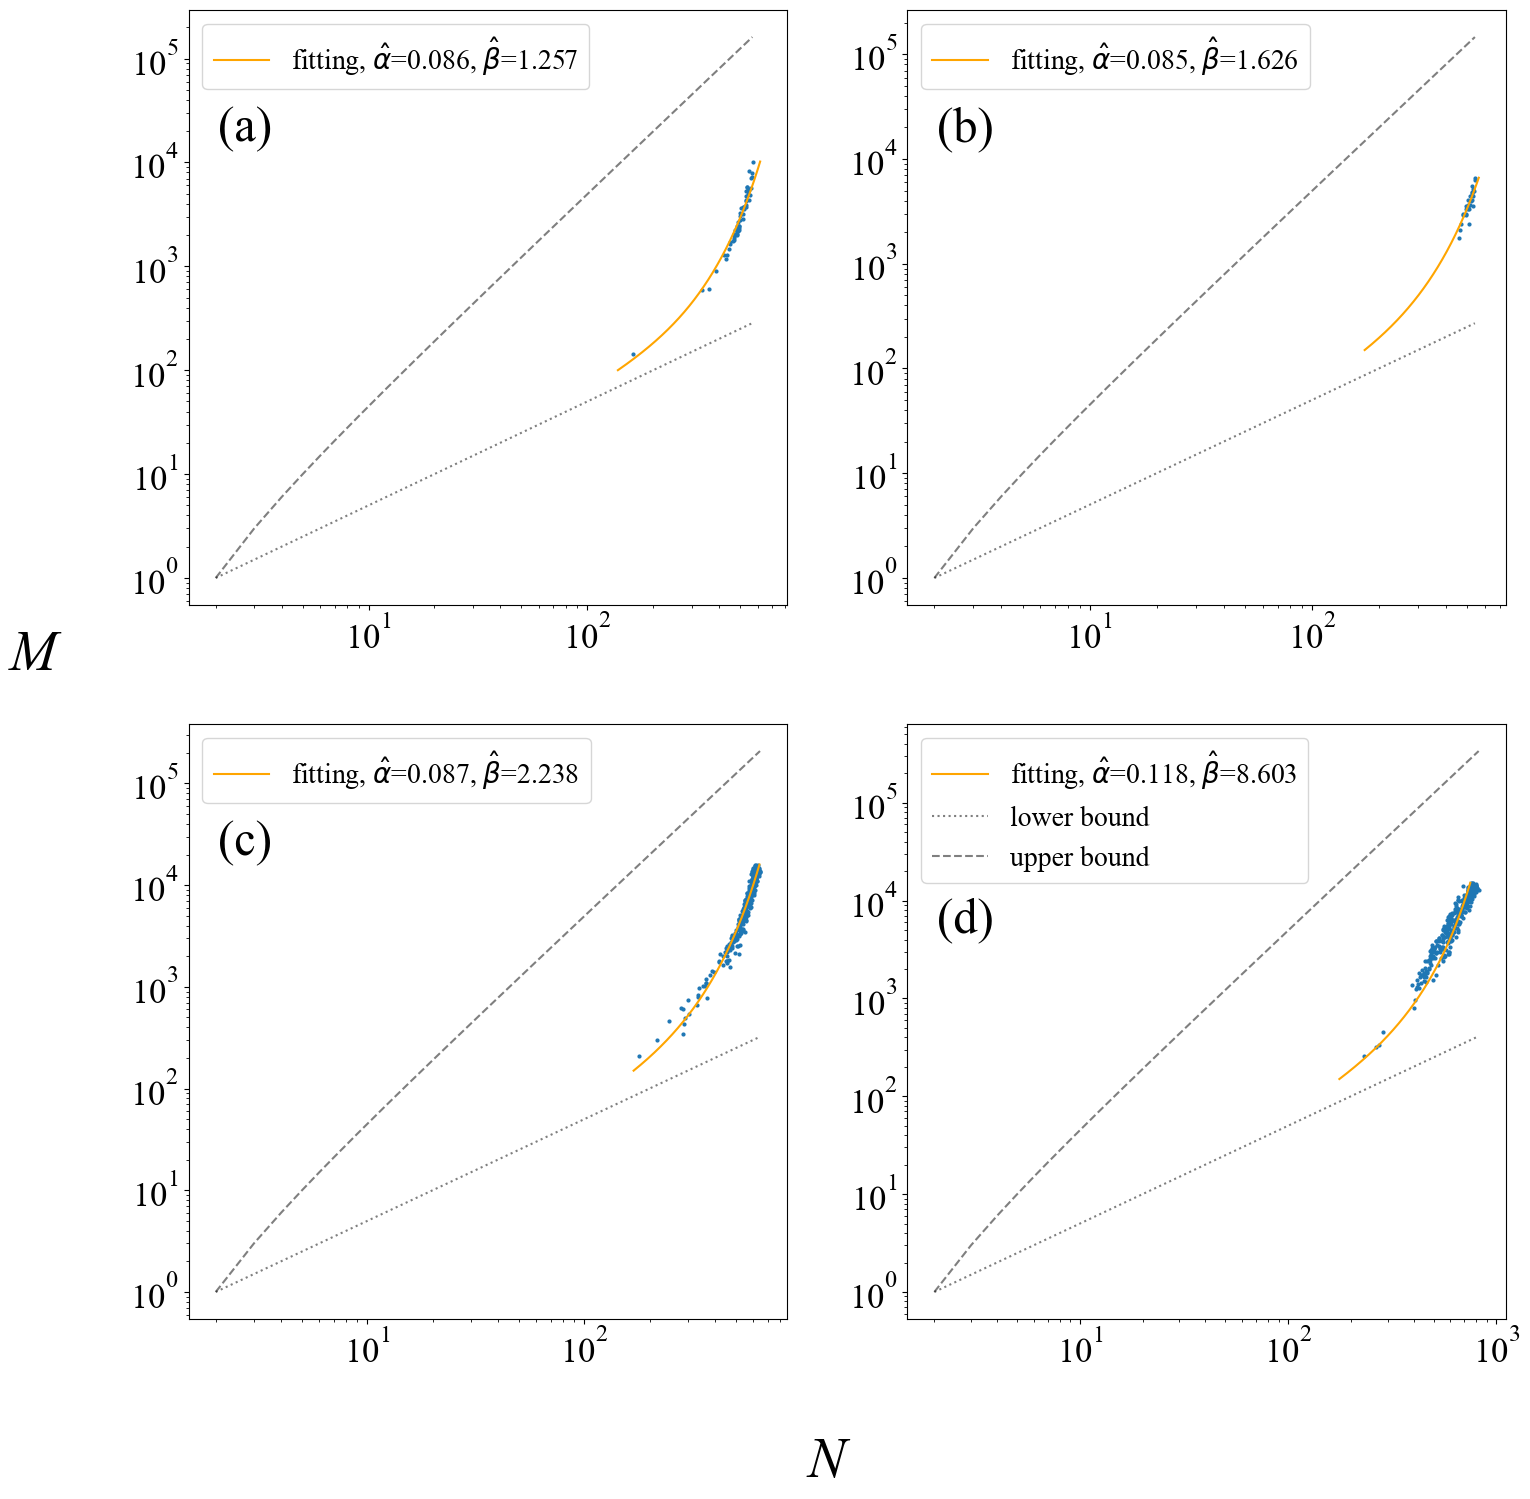

In [69]:
# 2021年のkappaと距離の関係
# olsを用いて回帰分析を行う
# plt.figure(figsize=(10, 10))

# fontをtimes new romanに変更
plt.rcParams['font.family'] = 'Times New Roman'
# 軸らベルのフォントサイズを設定
plt.rcParams['axes.labelsize'] = 20

fig, axes = plt.subplots(2, 2, figsize=(17, 17))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

ax1.plot(node_lockdown, edge_lockdown, "o", markersize=2)
ax1.text(0.05, 0.78, "(a)", transform=ax1.transAxes, fontsize=35)
x = np.arange(2, np.max(node_lockdown))
y = np.arange(100, np.max(edge_lockdown))
alpha,beta=alpha_lockdown,beta_lockdown
ax1.plot(Model3(y), y, "-", c="orange", label=fr"fitting, $\hat{{\alpha}}$={round(alpha, 3):.3f}, $\hat{{\beta}}$={round(beta, 3):.3f}")
ax1.plot(x,x/2, c = "black", alpha= 0.5, ls = ":")
ax1.plot(x,x*(x-1)/2, c = "black", alpha = 0.5, ls = "--")
#ax1.plot(kappa_distance_2020_df["kappa"], result.fittedvalues, color="red", label="Regression line")
ax1.legend(prop={"size": 20}, loc="upper left")
# ラベルのフォントサイズを設定
# ax1.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax1.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax1.tick_params(labelsize=25)

ax2.plot(node_stayhome, edge_stayhome, "o", markersize=2)
ax2.text(0.05, 0.78, "(b)", transform=ax2.transAxes, fontsize=35)
x = np.arange(2, np.max(node_stayhome))
y = np.arange(150, np.max(edge_stayhome))
alpha,beta=alpha_stayhome,beta_stayhome
ax2.plot(Model3(y), y, "-", c="orange", label=fr"fitting, $\hat{{\alpha}}$={round(alpha, 3):.3f}, $\hat{{\beta}}$={round(beta, 3):.3f}")
ax2.plot(x,x/2,  c = "black", alpha= 0.5, ls = ":")
ax2.plot(x,x*(x-1)/2,  c = "black", alpha = 0.5, ls = "--")
#ax2.plot(kappa_distance_2021_df["kappa"], result2.fittedvalues, color="red", label="Regression line")
ax2.legend(prop={"size": 20}, loc="upper left")
# ラベルのフォントサイズを設定
# ax2.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax2.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax2.tick_params(labelsize=25)

ax3.plot(node_2021, edge_2021, "o", markersize=2)
x = np.arange(2, np.max(node_2021))
y = np.arange(150, np.max(edge_2021))
alpha,beta=alpha_2021,beta_2021
ax3.plot(Model3(y), y, "-", c="orange", label=fr"fitting, $\hat{{\alpha}}$={round(alpha, 3):.3f}, $\hat{{\beta}}$={round(beta, 3):.3f}")
ax3.text(0.05, 0.78, "(c)", transform=ax3.transAxes, fontsize=35)
ax3.plot(x,x/2, c = "black", alpha= 0.5, ls = ":")
ax3.plot(x,x*(x-1)/2, c = "black", alpha = 0.5, ls = "--")
#ax3.plot(kappa_distance_2022_df["kappa"], result3.fittedvalues, color="red", label="Regression line")
ax3.legend(prop={"size": 20}, loc="upper left")
# ラベルのフォントサイズを設定
# ax3.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax3.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax3.tick_params(labelsize=25)

ax4.plot(node_2022, edge_2022, "o", markersize=2)
x = np.arange(2, np.max(node_2022))
y = np.arange(150, np.max(edge_2022))
alpha,beta=alpha_2022,beta_2022
ax4.plot(Model3(y), y, "-", c="orange", label=fr"fitting, $\hat{{\alpha}}$={round(alpha, 3):.3f}, $\hat{{\beta}}$={round(beta, 3):.3f}")
ax4.text(0.05, 0.65, "(d)", transform=ax4.transAxes, fontsize=35)
ax4.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
ax4.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#ax4.plot(kappa_distance_2023_df["kappa"], result4.fittedvalues, color="red", label="Regression line")
ax4.legend(prop={"size": 20}, loc="upper left")
# ラベルのフォントサイズを設定
# ax4.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax4.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax4.tick_params(labelsize=25)

#fig.xscale("log")
#fig.yscale("log")

fig.supxlabel(r"N", fontsize=40).set_fontstyle("italic")
fig.supylabel(r"M", fontsize=40, rotation=0).set_fontstyle("italic")


# 各軸を対数にする
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax4.set_xscale("log")
ax4.set_yscale("log")

# xラベルは100から

"""
ax1.set_xlim(50, 1000)
ax1.set_ylim(50, 100000)
ax2.set_xlim(50, 1000)
ax2.set_ylim(50, 100000)
ax3.set_xlim(50, 1000)
ax3.set_ylim(50, 100000)
ax4.set_xlim(50, 1000)
ax4.set_ylim(50, 100000)
"""

"""
plt.xlabel(r"$\hat{\kappa}$")
plt.ylabel("Distance (km)")
#plt.tick_params(labelsize=40)
plt.legend(prop={"size": 8})
"""
plt.savefig("../fig/cssj/fit_fourpanels.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()


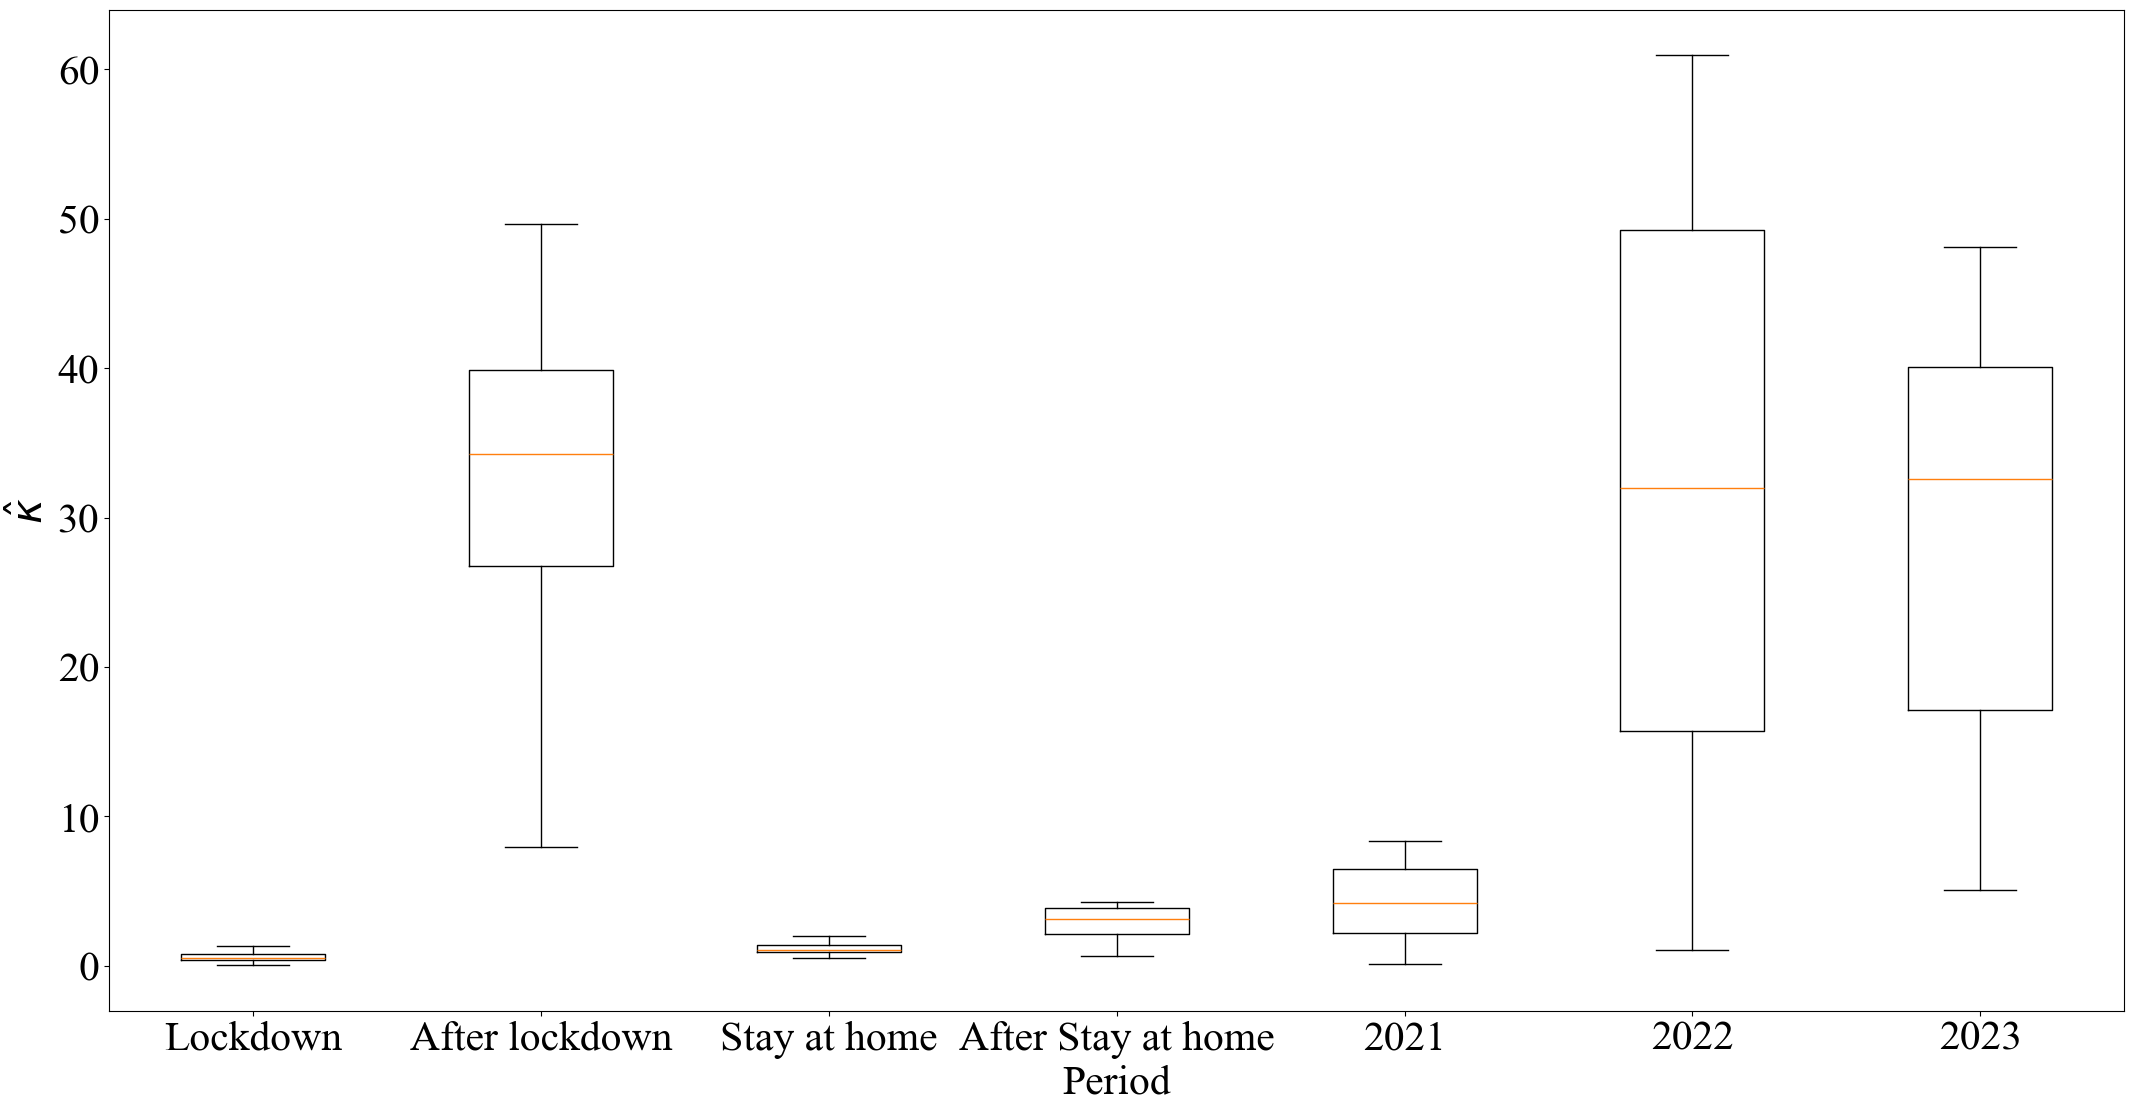

In [50]:
# box plot
plt.figure(figsize=(26,13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

label_list = ["Lockdown", "After lockdown", "Stay at home", "After Stay at home", "2021", "2022", "2023"]

data = [kappa_lockdown, kappa_after_lockdown, kappa_stayhome, kappa_after_stayhome, kappa_2021, kappa_2022, kappa_2023]
plt.boxplot(data, labels=label_list[:7], showfliers=False)
# plt.yscale("log")
plt.tick_params(labelsize=30)
plt.xlabel("Period")
plt.ylabel(r"$\hat{\kappa}$") 
plt.savefig("../fig/cssj/kappa_boxplot.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

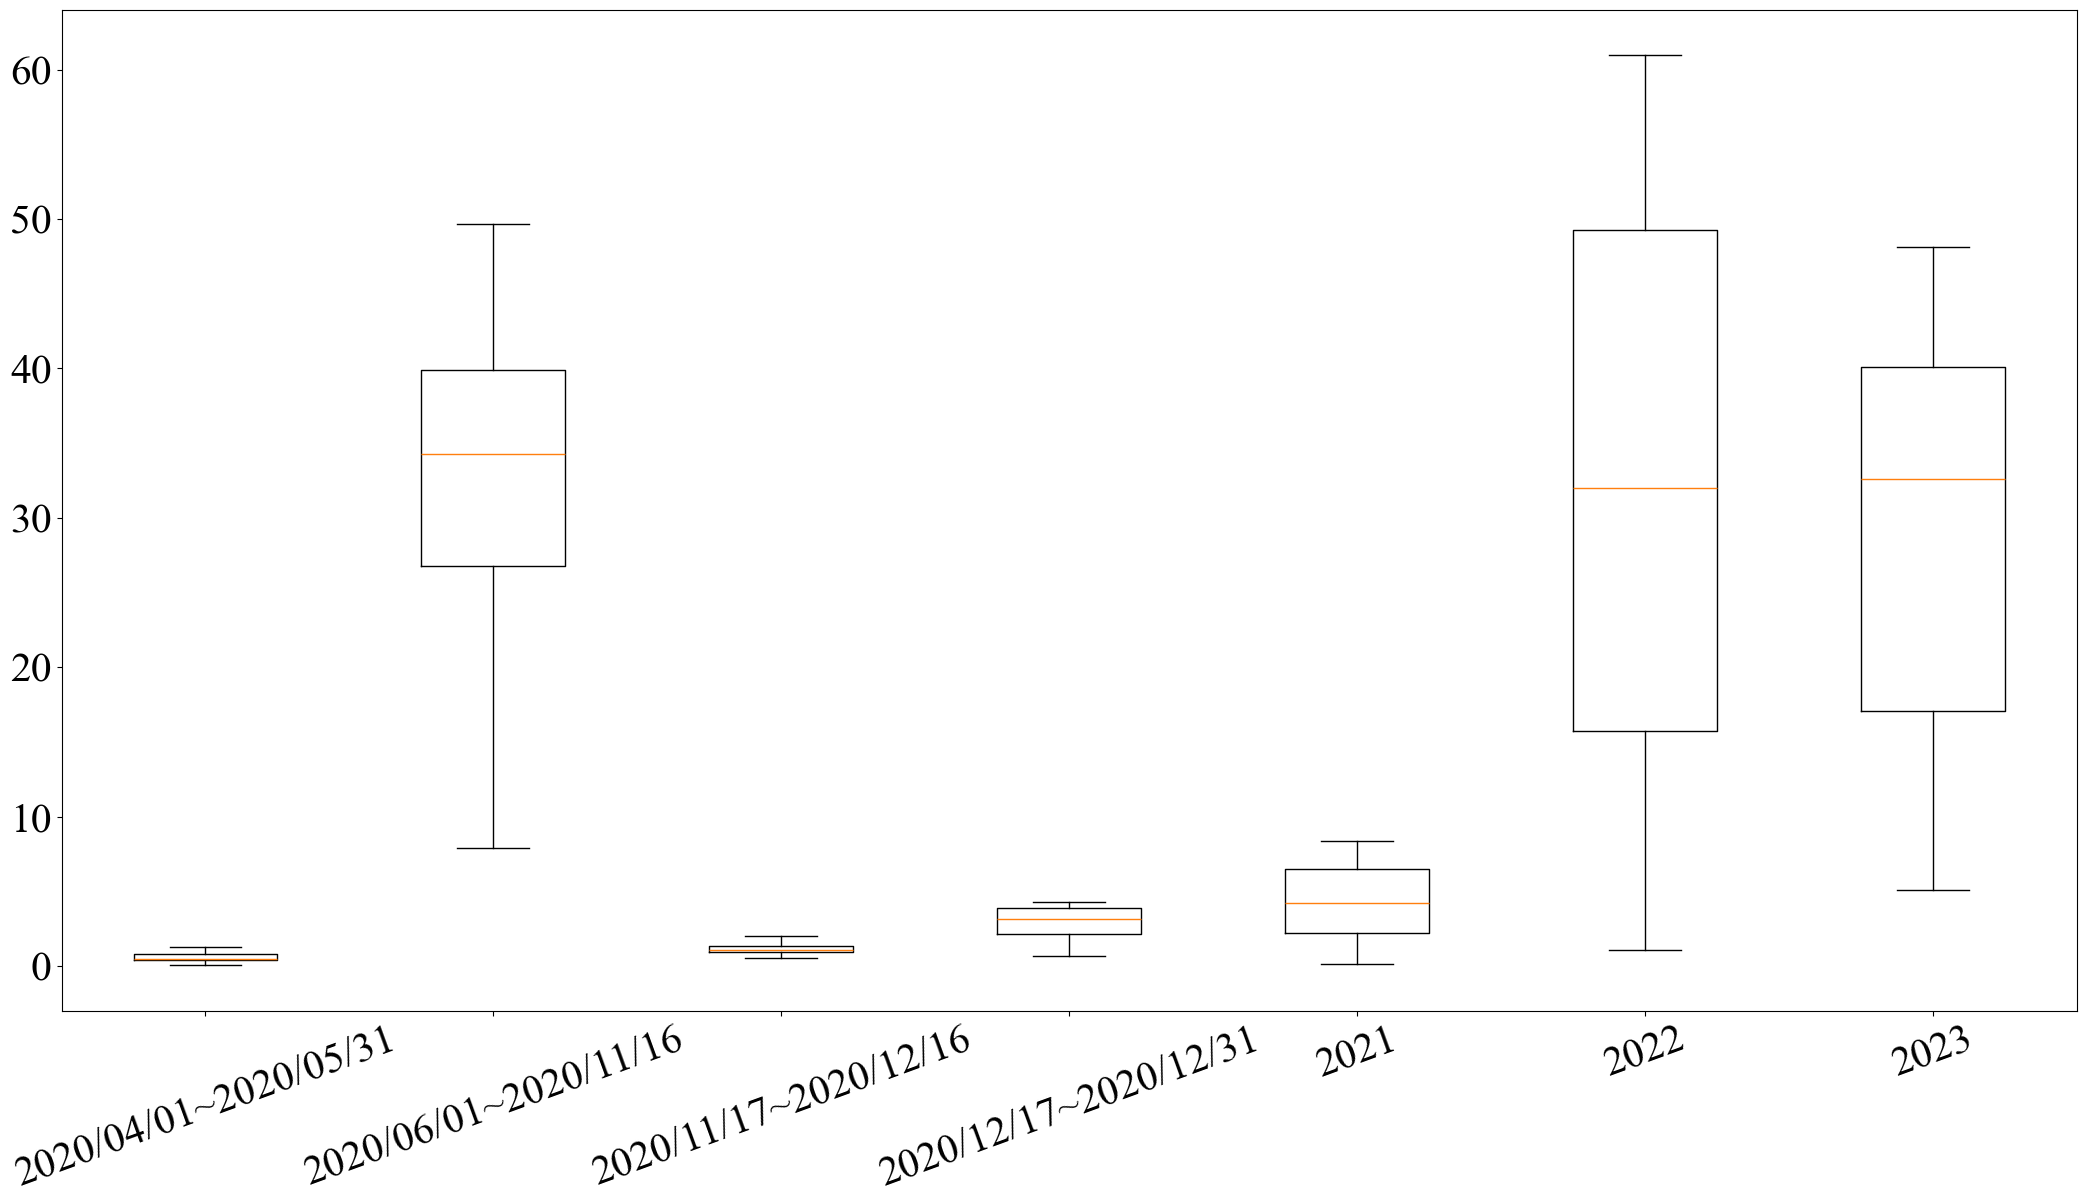

In [33]:
# box plot
plt.figure(figsize=(26,13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

label_list = ["2020/04/01~2020/05/31", "2020/06/01~2020/11/16", "2020/11/17~2020/12/16", "2020/12/17~2020/12/31", "2021", "2022", "2023"]

data = [kappa_lockdown, kappa_after_lockdown, kappa_stayhome, kappa_after_stayhome, kappa_2021, kappa_2022, kappa_2023]
plt.boxplot(data, labels=label_list[:7], showfliers=False)
# plt.yscale("log")
plt.tick_params(labelsize=30)
# 軸を回転させる
plt.xticks(rotation=20)
# plt.yticks(rotation=90)
# plt.xlabel("Period")
# plt.ylabel(r"$\hat{\kappa}$", fontsize=50)
plt.savefig("../fig/cssj/kappa_boxplot.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()